In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from utils import *
from plotters import *
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from matplotlib import cm

In [3]:
data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

def sample_loss(params):
    print('C = {0}, gamma = {1}'.format(params[0], params[1]))
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

In [4]:
lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

# real_loss = [sample_loss(params) for params in param_grid]
real_loss = np.load('real_loss.npy')
# np.save('real_loss.npy', real_loss)

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

array([ 0.375     , -2.15789474])

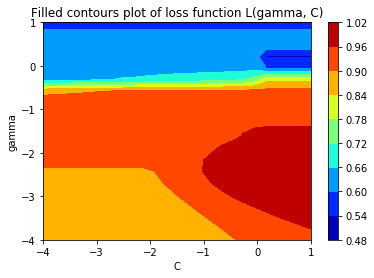

In [5]:
C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape), cmap=cm.jet)
plt.colorbar(cp)
plt.title('Filled contours plot of loss function L(gamma, C)')
plt.xlabel('C')
plt.ylabel('gamma')
# plt.savefig('/Users/thomashuijskens/Personal/gp-optimisation/figures/real_loss_contour.png', bbox_inches='tight')
plt.show()

In [6]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

C = -2.750186369333038, gamma = -0.16854803111848193
C = -1.0897907264808047, gamma = -1.5949217221818204
C = -2.9576881834773197, gamma = -2.7399612838734657
C = 0.9752173692297452, gamma = -3.9777925798560734
C = 0.9993357219412218, gamma = -1.1834489673984754
C = -0.2182939463052902, gamma = -2.6534978262444104
C = -0.9753307195050511, gamma = -3.9986370810002145
C = 0.9989526248795784, gamma = -2.572428441976276
C = 0.12466431087869534, gamma = -2.0170624542474647
C = 0.4190927084963665, gamma = -2.406920281687852
C = -0.2554147349457363, gamma = -2.0978180389325165
C = 0.9997442598646211, gamma = -3.033353429778244
C = 0.9973016914802155, gamma = -2.1045282037826416
C = 0.5878132284207149, gamma = -2.1285482484390164
C = 0.1515021143574229, gamma = -2.2363323694050394
C = 0.997928676597688, gamma = -2.291560914453842
C = 0.38422367334166196, gamma = -2.15229964445873
C = 0.7136954435214786, gamma = -2.276696274776707
C = 0.2803757174616921, gamma = -2.183587679561887
C = 0.0357405

/home/jz853/anaconda3/envs/jz853/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


C = 0.43812880903171436, gamma = -2.206447226801708
C = 0.6886144240933003, gamma = -2.3980374272326257
C = 0.03540561931033004, gamma = -1.880138173884057
C = 0.22670451590318752, gamma = -2.0990782342945526
C = 0.6320693854749626, gamma = -2.1068117759416145
C = 0.3822613423760055, gamma = -2.1035821574845883
C = 0.09136108090146422, gamma = -2.1123649480641435
C = 0.549305892385008, gamma = -2.215235090725951


/home/jz853/Dropbox/FINE_src/LOUPE_MoDL_GE_Recon/bayesOpt/plotters.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)
/home/jz853/Dropbox/FINE_src/LOUPE_MoDL_GE_Recon/bayesOpt/plotters.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)
/home/jz853/Dropbox/FINE_src/LOUPE_MoDL_GE_Recon/bayesOpt/plotters.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created throug

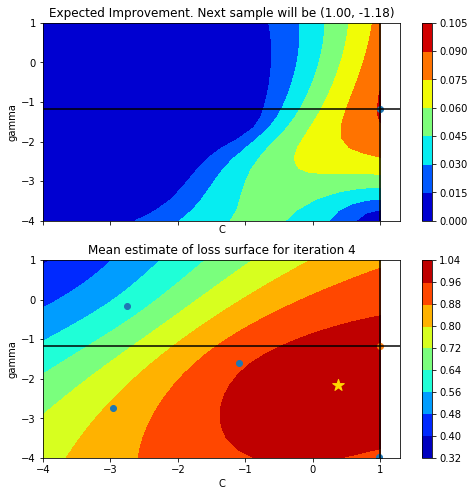

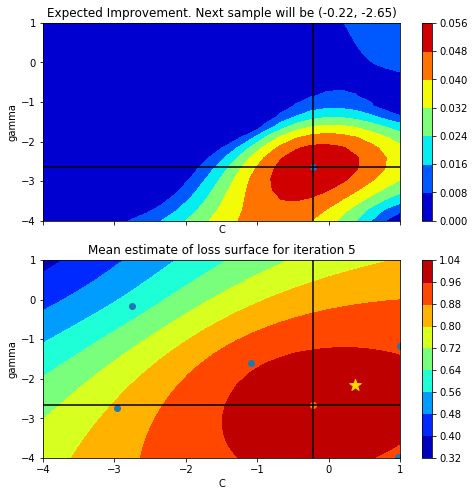

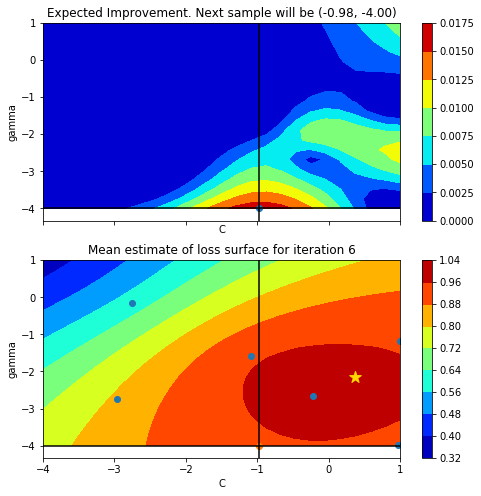

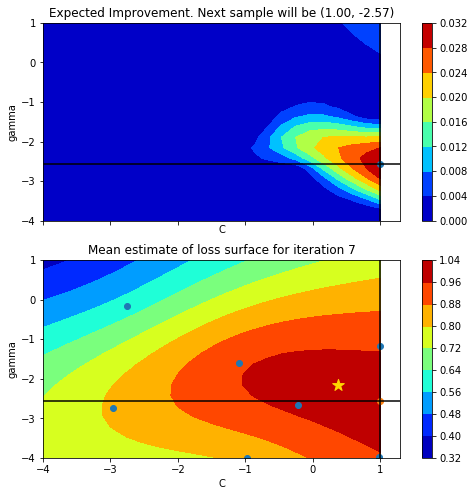

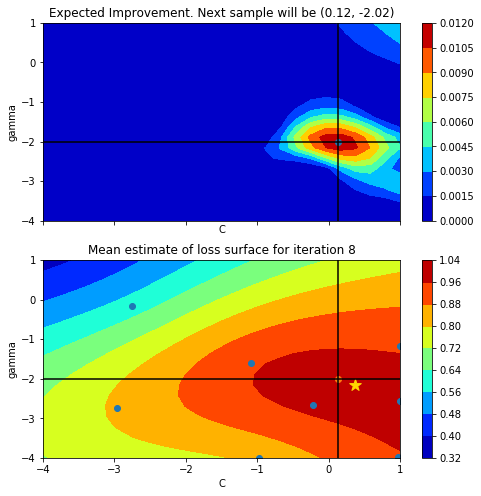

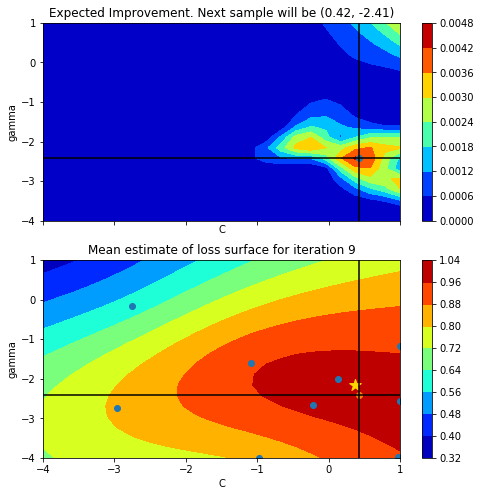

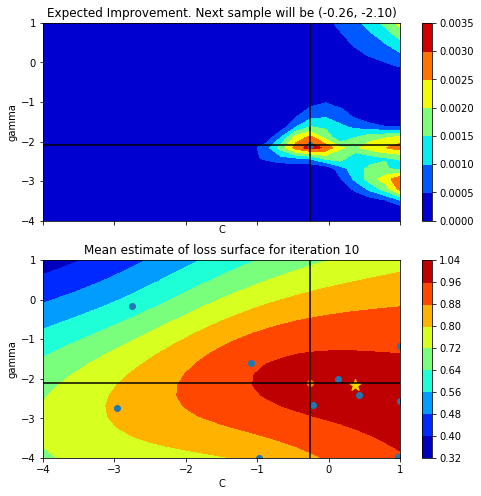

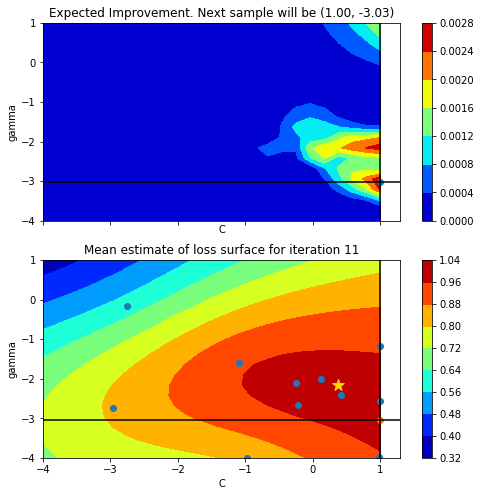

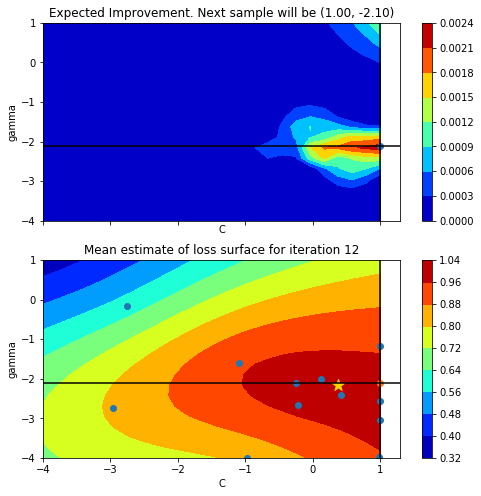

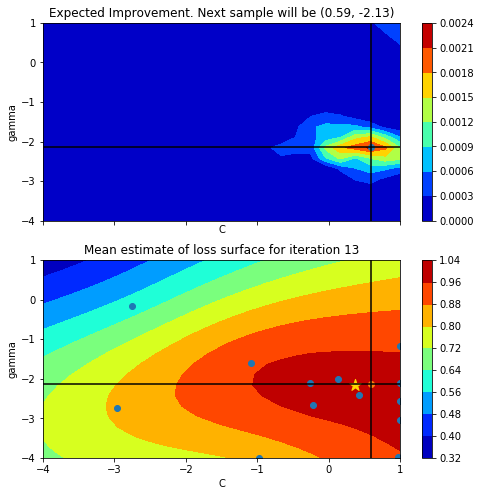

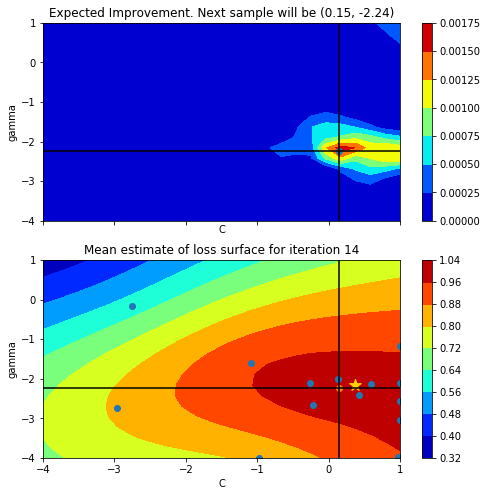

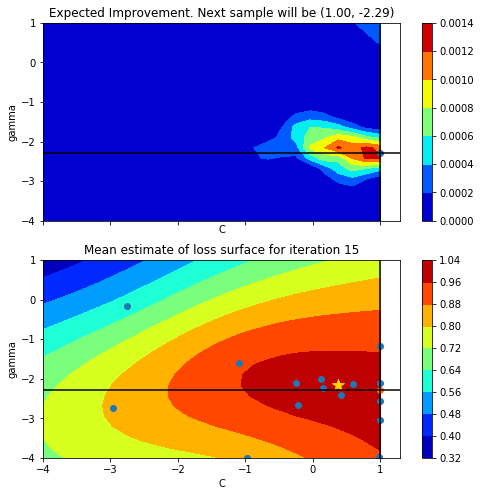

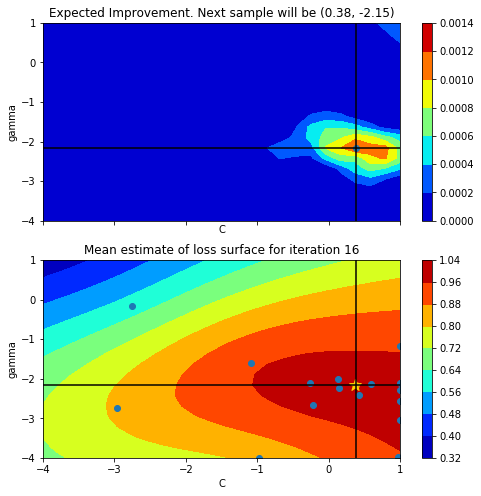

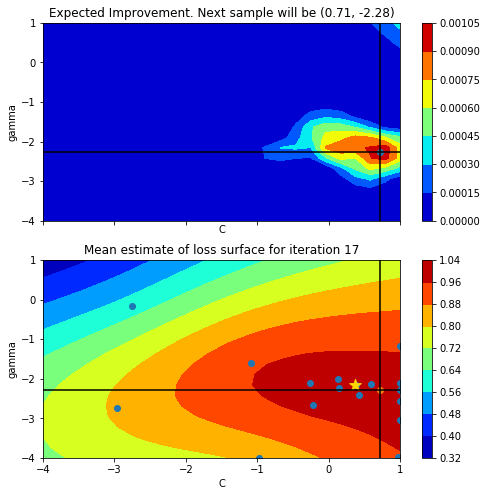

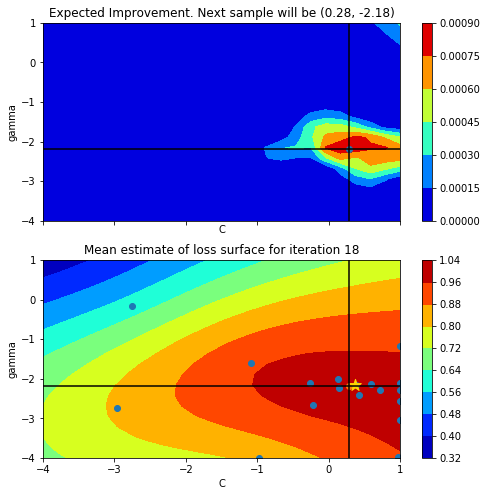

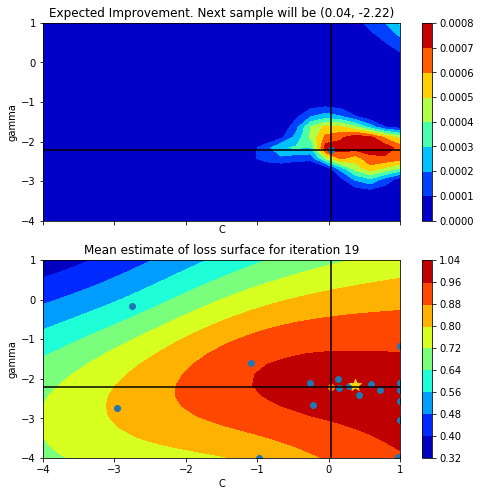

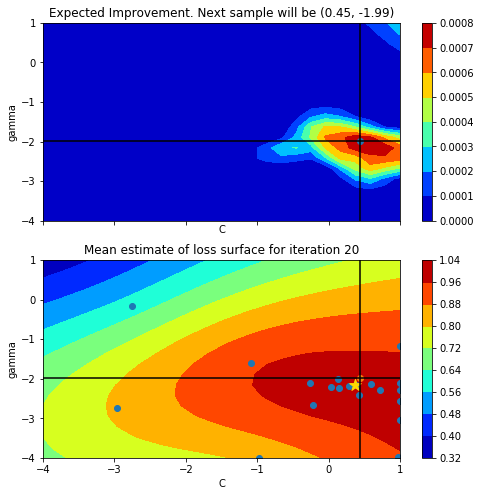

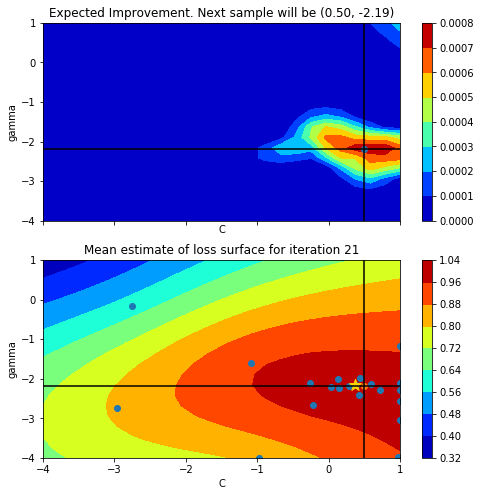

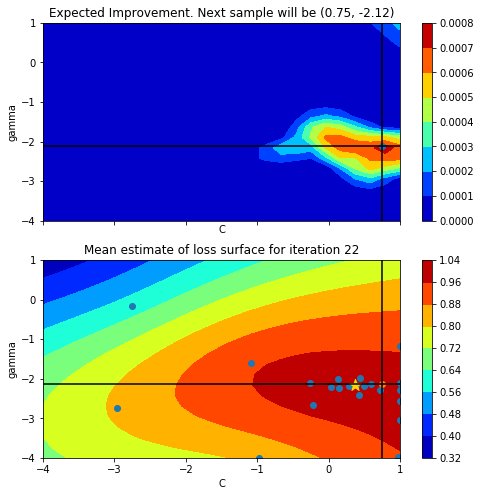

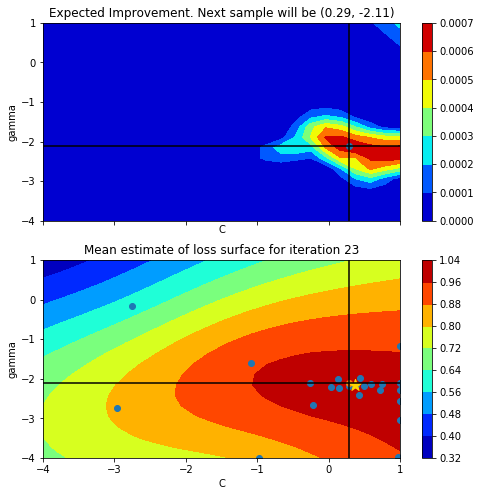

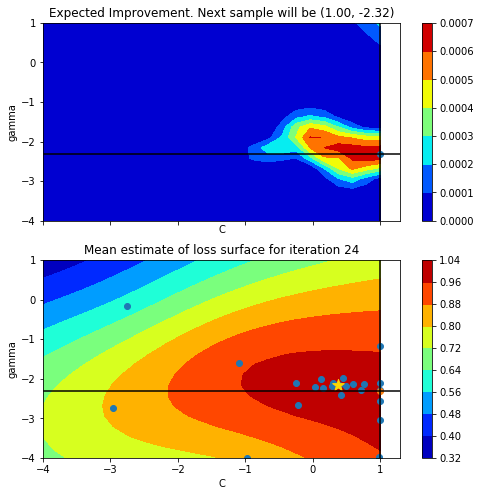

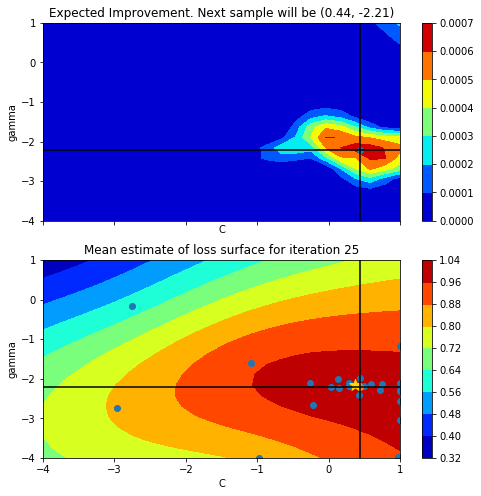

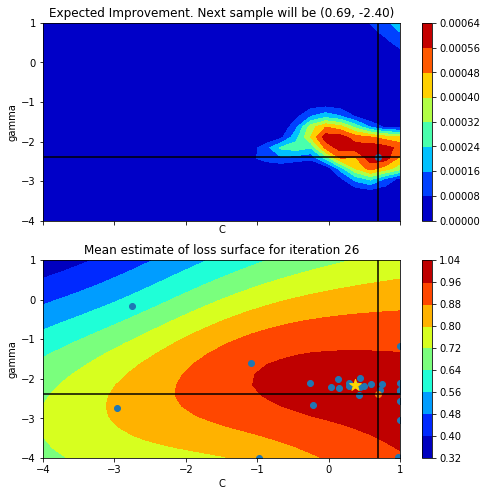

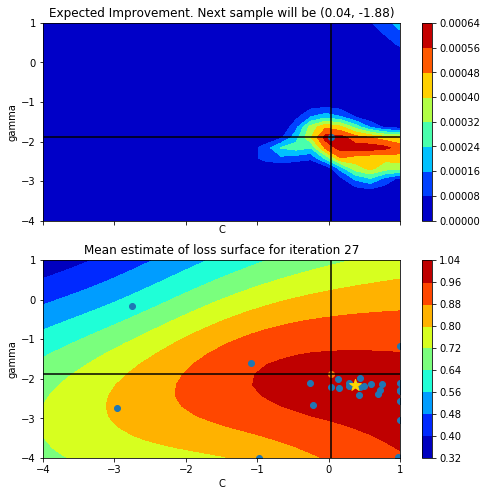

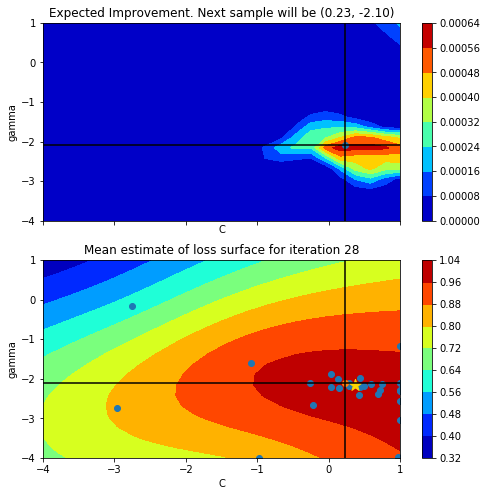

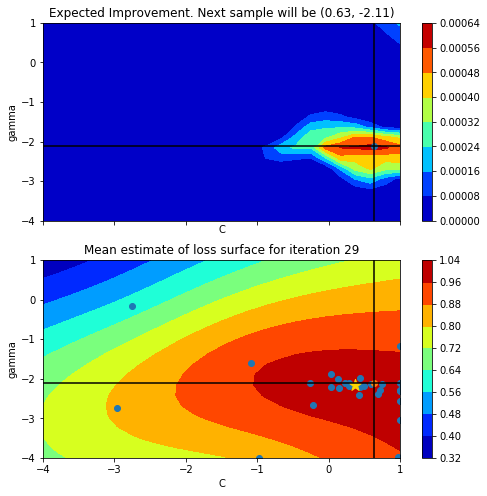

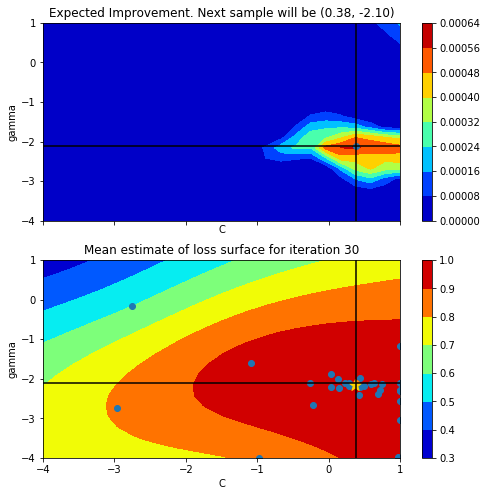

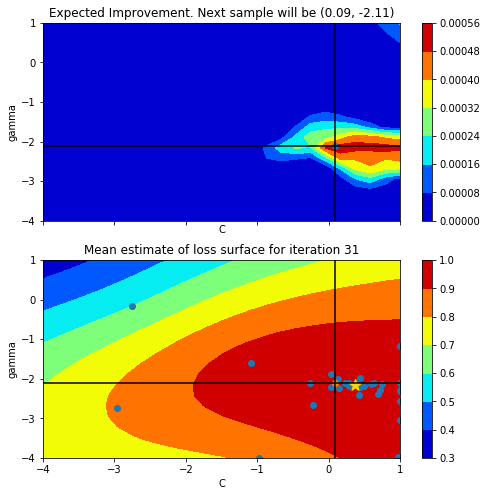

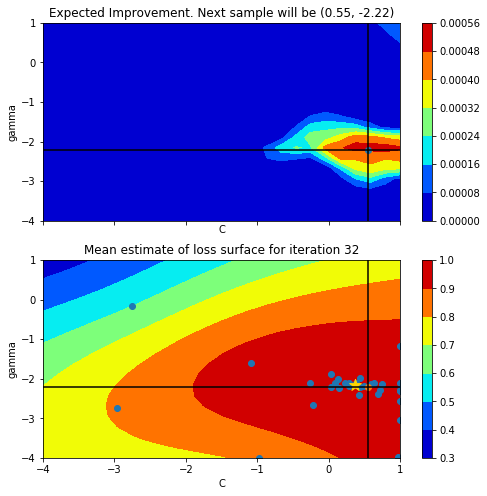

In [7]:
plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=[0.375, -2.15789474])